In [1]:
import tensorflow as tf
tf.__version__

'2.2.0-rc1'

In [0]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import numpy as np 

In [3]:
tokenizer = Tokenizer()
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt
data = open('/tmp/sonnets.txt').read()

corpus = data.lower().split("\n")


tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

--2020-03-29 16:07:32--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 2404:6800:4003:c03::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91.38K  --.-KB/s    in 0.001s  

2020-03-29 16:07:32 (172 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]



In [4]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150, return_sequences = True)))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 100)           321100    
_________________________________________________________________
bidirectional (Bidirectional (None, 10, 300)           301200    
_________________________________________________________________
dropout (Dropout)            (None, 10, 300)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1605)              162105    
_________________________________________________________________
dense_1 (Dense)              (None, 3211)              5156866   
Total params: 6,101,671
Trainable params: 6,101,671
Non-trainable params: 0
______________________________________________

In [5]:
 history = model.fit(predictors, label, epochs=100, verbose=1)

Epoch 1/100
484/484 [==============================] - 5s 11ms/step - loss: 6.9119 - accuracy: 0.0197
Epoch 2/100
484/484 [==============================] - 5s 11ms/step - loss: 6.5027 - accuracy: 0.0218
Epoch 3/100
484/484 [==============================] - 5s 11ms/step - loss: 6.4144 - accuracy: 0.0248
Epoch 4/100
484/484 [==============================] - 5s 11ms/step - loss: 6.2951 - accuracy: 0.0291
Epoch 5/100
484/484 [==============================] - 5s 11ms/step - loss: 6.1949 - accuracy: 0.0330
Epoch 6/100
484/484 [==============================] - 5s 11ms/step - loss: 6.1116 - accuracy: 0.0381
Epoch 7/100
484/484 [==============================] - 5s 11ms/step - loss: 6.0274 - accuracy: 0.0389
Epoch 8/100
484/484 [==============================] - 6s 11ms/step - loss: 5.9507 - accuracy: 0.0437
Epoch 9/100
484/484 [==============================] - 5s 11ms/step - loss: 5.8669 - accuracy: 0.0509
Epoch 10/100
484/484 [==============================] - 5s 11ms/step - loss: 5.761

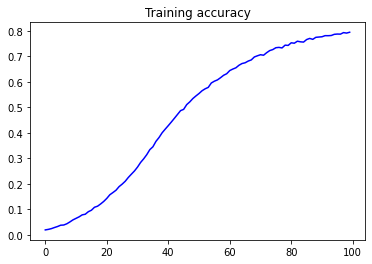

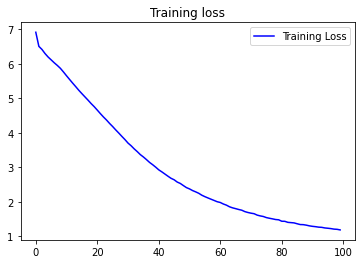

In [7]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [11]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
from pprint import pprint
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = np.argmax(model.predict(token_list), axis=-1)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
pprint(seed_text)

("Help me Obi Wan Kenobi, you're my only hope know thy mind ever words brought "
 'new forth thine desert eyes young a living hue give thee up give crave lusty '
 'face brought back back back back back ruining thorns did grow controlling '
 "place delight inhearse relief staineth warm'd burn time give moan his height "
 'be mother aside brought ill new brought alone than life when so prove prove '
 "thee bright love bright gain be white dying would see my defects ' and me so "
 'free brought still bright friend thee as those skill esteem new spent lies '
 'grow new flowers flowers held bearing gain lies aside decays bar grow')
